In [9]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

# Simple Linear Regression

In [10]:
lung=pd.read_csv('LungDisease.csv')
lung

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1
...,...,...
117,450,22
118,490,22
119,500,22
120,370,23


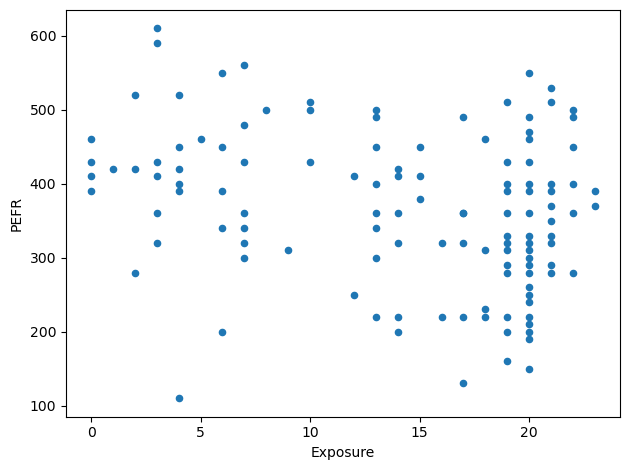

In [11]:
lung.plot.scatter(x='Exposure',y='PEFR')
plt.tight_layout()
plt.show()

In [12]:
predictors=['Exposure']
outcome='PEFR'

model=LinearRegression()
model.fit(lung[predictors],lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


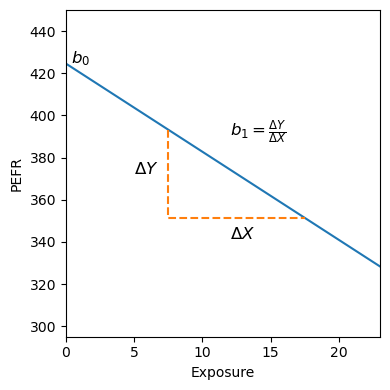

In [13]:

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

In [14]:
fitted=model.predict(lung[predictors])
residuals=lung[outcome]-fitted

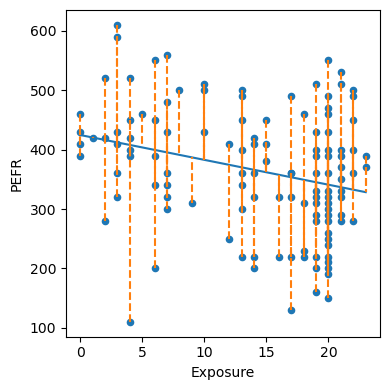

In [15]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

how to predit for example. put [[]] to make the number 2D array

In [16]:
model.predict([[20]])

C:\Users\P6049834\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([340.89127686])

# Multiple Linear Regression

In [17]:
house=pd.read_csv('house_sales.csv',sep='\t')
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [18]:
house.columns

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction'],
      dtype='object')

In [19]:
house[[#'DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       #'zhvi_px', 'zhvi_idx', 
    'AdjSalePrice', #'NbrLivingUnits', 
    'SqFtLot',
       'SqFtTotLiving', #'SqFtFinBasement', 
    'Bathrooms', 'Bedrooms',
       'BldgGrade']].head()
    #'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       #'ImpsVal', 'ZipCode', 'NewConstruction'

,AdjSalePrice,SqFtLot,SqFtTotLiving,Bathrooms,Bedrooms,BldgGrade
1,300805.0,9373,2400,3.00,6,7
2,1076162.0,20156,3764,3.75,4,10
3,761805.0,26036,2060,1.75,4,8
4,442065.0,8618,3200,3.75,5,7
5,297065.0,8620,1720,1.75,4,7


In [20]:
predictors=['SqFtLot','SqFtTotLiving','Bathrooms', 'Bedrooms','BldgGrade']
outcome='AdjSalePrice'

house_lm=LinearRegression()
house_lm.fit(house[predictors],house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtLot: -0.06046682065276247
 SqFtTotLiving: 228.83060360236112
 Bathrooms: -19442.840398321165
 Bedrooms: -47769.95518521434
 BldgGrade: 106106.96307898076


In [21]:
house_lm.predict([[8618,3200,3.75,5,7]])

C:\Users\P6049834\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([640853.77441207])

# Assesing the Model

In [22]:
fitted=house_lm.predict(house[predictors])
RMSE=np.sqrt(mean_squared_error(house[outcome], fitted))
r2=r2_score(house[outcome],fitted)
print(f'RMSE:{RMSE:.0f}')
print(f'r2:{r2:.4f}')

RMSE:261220
r2:0.5406


While scikit-learn provides a variety of different metrics, statsmodels provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to scikit-learn and one that allows specifying R-style formulas. Here we use the first approach. As statsmodels doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the pandas method assign for this.

In [23]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        11:44:41   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtLot          -0.0605      0.061     -0.988

t값이 높을수록, p값이 낮을수록 예측변수는 유의미함*페이지177

# Model Selection and Stepwise Regression

In [24]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
house[predictors]

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction
1,2400,9373,3.00,6,7,Multiplex,2,0,1991,0,False
2,3764,20156,3.75,4,10,Single Family,1,1452,2005,0,True
3,2060,26036,1.75,4,8,Single Family,1,900,1947,0,False
4,3200,8618,3.75,5,7,Single Family,1,1640,1966,0,False
5,1720,8620,1.75,4,7,Single Family,1,0,1948,0,False
...,...,...,...,...,...,...,...,...,...,...,...
27057,1480,5468,1.75,3,7,Single Family,1,590,1951,0,False
27058,4720,23914,4.50,4,11,Single Family,1,910,2000,0,False
27061,1070,11170,1.00,4,6,Single Family,1,0,1971,0,False
27062,1345,6223,2.00,3,7,Single Family,1,0,1939,0,False


In [25]:

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        11:44:41   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [26]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420169
 BldgGrade: 137159.56022619663
 YrBuilt: -3565.424939249451
 Bedrooms: -51947.38367361402
 Bathrooms: 42396.16452772084
 PropertyType_Townhouse: 84479.16203300131
 SqFtFinBasement: 7.046974967551216
 PropertyType_Single Family: 22912.055187017668


y 랑 X.columns지정

# Weighted Regression

In [27]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['weight']=house.Year - 2005

In [28]:
house.columns

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction', 'Year', 'weight'],
      dtype='object')

In [29]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,-0.060467,245.024089
1,SqFtLot,228.830604,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [30]:
house.PropertyType.head(6)

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
6        Townhouse
Name: PropertyType, dtype: object

In [31]:
pd.get_dummies(house['PropertyType']).head()

,Multiplex,Single Family,Townhouse
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0


In [32]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))
               

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [33]:
house.columns

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction', 'Year', 'weight'],
      dtype='object')

In [34]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503802
 SqFtLot: -0.07036798136813438
 Bathrooms: -15979.013473415285
 Bedrooms: -50889.732184830005
 BldgGrade: 109416.305161462
 PropertyType_Single Family: -84678.21629549272
 PropertyType_Townhouse: -115121.97921609186


In [35]:
X

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,0,0
2,3764,20156,3.75,4,10,1,0
3,2060,26036,1.75,4,8,1,0
4,3200,8618,3.75,5,7,1,0
5,1720,8620,1.75,4,7,1,0
...,...,...,...,...,...,...,...
27057,1480,5468,1.75,3,7,1,0
27058,4720,23914,4.50,4,11,1,0
27061,1070,11170,1.00,4,6,1,0
27062,1345,6223,2.00,3,7,1,0


In [37]:
pd.DataFrame(house['ZipCode'].value_counts()).transpose()

,98038,98103,98042,98115,98117,98052,98034,98033,98059,98074,...,98051,98024,98354,98050,98057,98288,98224,98068,98113,98043
ZipCode,788,671,641,620,619,614,575,517,513,502,...,32,31,9,7,4,4,3,1,1,1


In [41]:
house = pd.read_csv('house_sales.csv', sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


각 우편번호에 대한 잔차의 중간값을 계산하고, 중간값으로 정렬한 우편번호를 5개의 그룹으로 분할

In [42]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

In [43]:
house

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,6,7,1991,0,0,70000,229000,98002,False,2
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,4,10,2005,0,0,203000,590000,98166,True,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,4,8,1947,0,0,183000,275000,98166,False,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,5,7,1966,0,0,104000,229000,98168,False,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,4,7,1948,0,0,104000,205000,98168,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27057,2011-04-08,325000,9842300710,Single Family,2011-04-01,318700,0.732307,443803.0,1,5468,...,3,7,1951,0,0,201000,172000,98126,False,3
27058,2007-09-28,1580000,9845500010,Single Family,2007-09-01,433500,0.996094,1586196.0,1,23914,...,4,11,2000,0,1,703000,951000,98040,False,4
27061,2012-07-09,165000,9899200010,Single Family,2012-07-01,325300,0.747472,220744.0,1,11170,...,4,6,1971,0,0,92000,130000,98055,False,0
27062,2006-05-26,315000,9900000355,Single Family,2006-05-01,400600,0.920496,342207.0,1,6223,...,3,7,1939,0,0,103000,212000,98166,False,2


# Interpreting the Rgression Equation

Correlated predictors
The result from the stepwise regression are

In [44]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420169
 BldgGrade: 137159.56022619663
 YrBuilt: -3565.424939249451
 Bedrooms: -51947.38367361402
 Bathrooms: 42396.16452772084
 PropertyType_Townhouse: 84479.16203300131
 SqFtFinBasement: 7.046974967551216
 PropertyType_Single Family: 22912.055187017668


In [45]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.53723021974
 BldgGrade: 248997.79366212635
 YrBuilt: -3211.744862155111
 PropertyType_Single Family: -19898.49534050197
 PropertyType_Townhouse: -47355.43687334427


# Confounding Variables(교란변수)

In [46]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.6126600558012
 SqFtLot: 0.454987138546608
 Bathrooms: 5928.425640001448
 Bedrooms: -41682.871840744505
 BldgGrade: 98541.18352725997
 PropertyType_Single Family: 19323.625287919775
 PropertyType_Townhouse: -78198.72092762342
 ZipGroup_1: 53317.17330659808
 ZipGroup_2: 116251.58883563541
 ZipGroup_3: 178360.53178793358
 ZipGroup_4: 338408.6018565204


교란변수를 넣음으로서 Bathroom, SqFtLot가 정상화

In [47]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        13:47:41   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

위의 식에서 물결(~) 기호는 'AdjSalePrice'와 'SqFtTotLiving', 'ZipGroup', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade', 'PropertyType'과 같은 독립 변수들 간의 관계를 선형 회귀 모델로 표현하기 위해 사용됩니다.

이 식은 선형 회귀 모델의 방정식을 지정하며, 물결 기호(~)의 왼쪽에는 종속 변수('AdjSalePrice')가 위치하고, 오른쪽에는 독립 변수들('SqFtTotLiving', 'ZipGroup', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade', 'PropertyType')이 위치합니다. 물결 기호는 종속 변수와 독립 변수들을 분리하는 역할을 합니다.

덧셈 기호(+)는 모델에 여러 개의 독립 변수가 포함되어 있다는 것을 나타냅니다. 이 경우, 'SqFtTotLiving', 'ZipGroup', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade', 'PropertyType'은 모델에 포함된 독립 변수들입니다.

별표()는 'SqFtTotLivingZipGroup'에서 사용되며, 상호작용 항(interaction term)을 나타냅니다. 여기서 'SqFtTotLiving'와 'ZipGroup'의 상호작용이 모델의 추가적인 독립 변수로 고려됩니다.

총적으로, 이 식은 선형 회귀 모델에서 종속 변수와 독립 변수들 간의 관계를 특정하는데 사용되며, 주요 효과 및 상호작용 항(있는 경우)을 포함합니다.

# Testing the Assumption: Regression Diagnostics(회귀진단)

In [52]:
house_98105=house.loc[house['ZipCode']==98105,]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Thu, 18 May 2023   Prob (F-statistic):          1.69e-103
Time:                        14:16:36   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

In [54]:
#표준화잔차, 가장작은 잔차
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.326731804078562


In [55]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115825


In [56]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


# Influential Values(영향값)

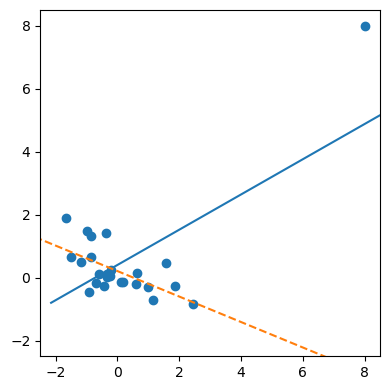

In [57]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

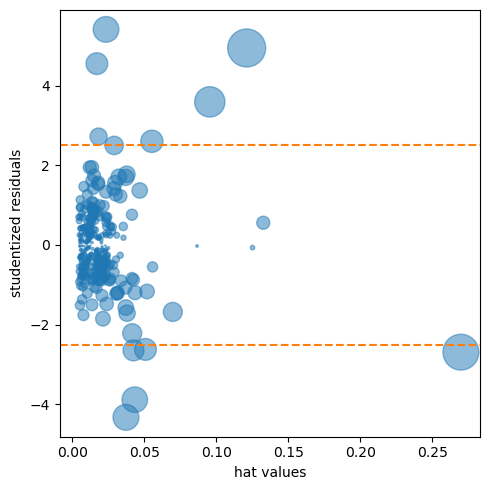

In [58]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [59]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


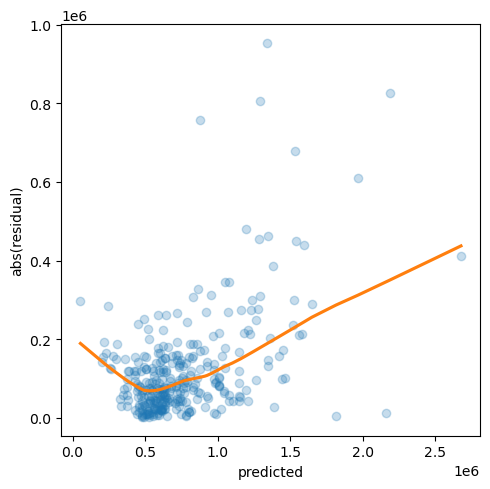

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

잔차의 분산이 고가의 주택일수록 증가, 마찬가지로 가격이 낮은 주택에서도 증가. 그러므로 이분산성 오차를 갖고 있다고 볼 수 있다.

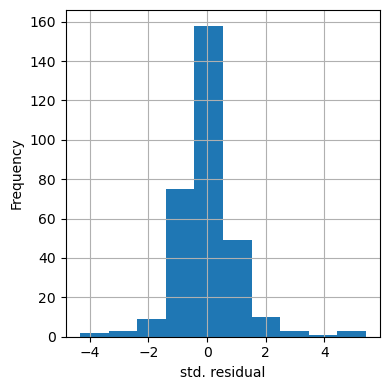

In [64]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

# Partial Residual Plots and Nonlinearity(편잔차그림과 비선형성)

예측모델리 예측변수와 결과변수 간의 관계를 얼마나 잘 설명하는지 시각화하는 방법

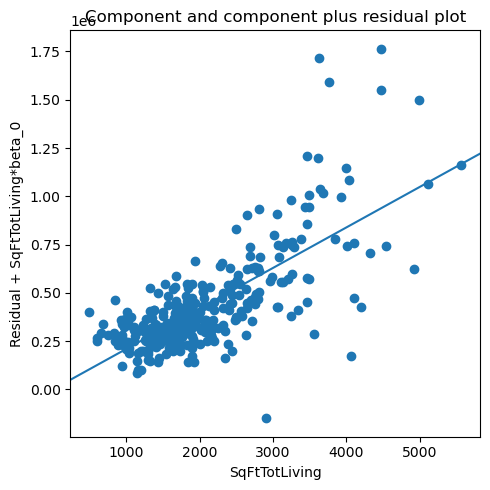

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

원래 큰 집에 500제곱피트를 추가하는 것 보다, 작은 집에 500제곱피트를 추가하는 것이 훨씬 더 큰 차이를 만든다.

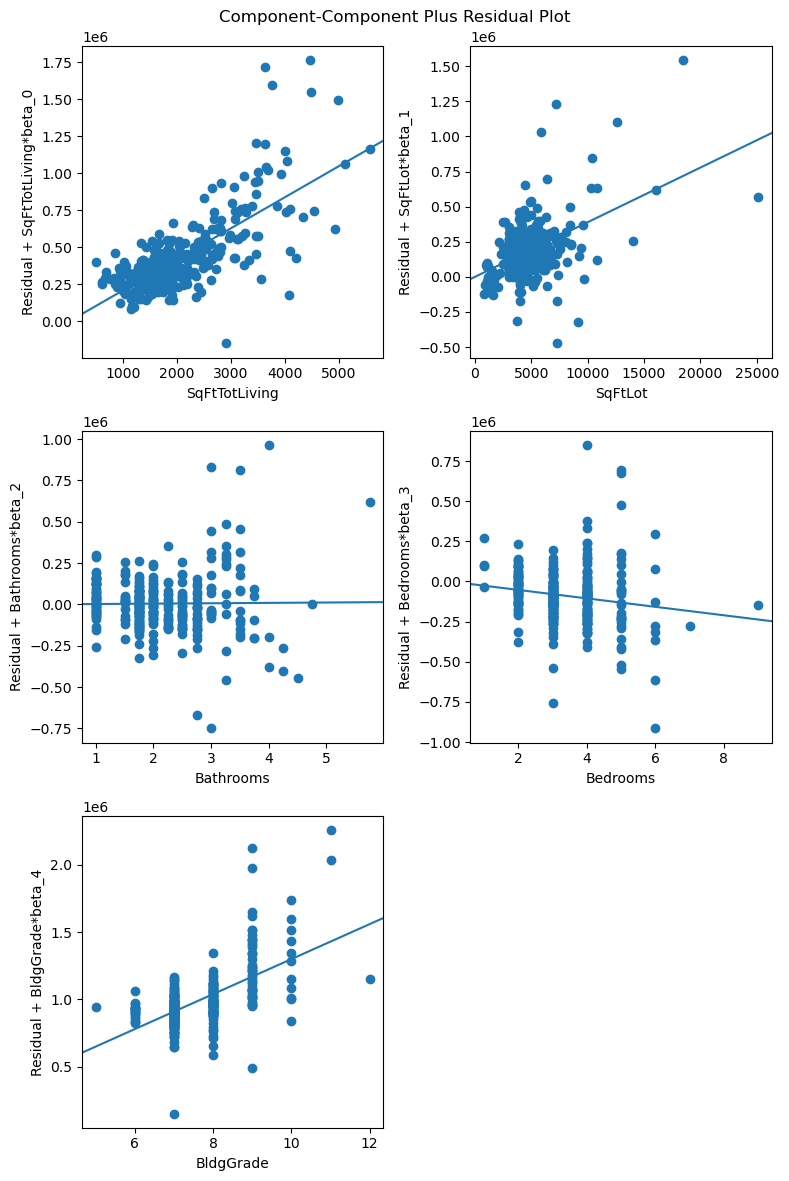

In [69]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

# Polynomial and Spline Regression(다항회귀와 스플라인 회귀)

In [70]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Thu, 18 May 2023   Prob (F-statistic):          9.95e-106
Time:                        16:02:55   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

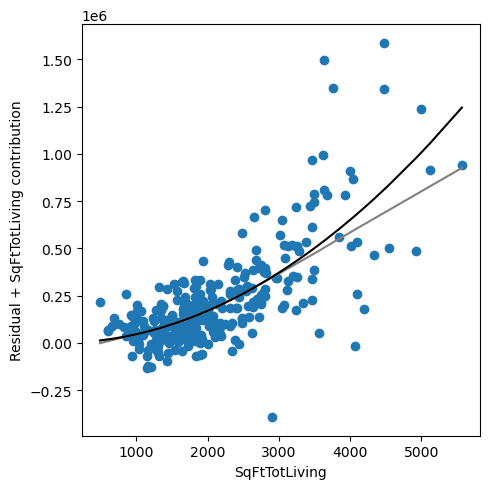

0.038791281682347745


In [71]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

In [72]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Thu, 18 May 2023   Prob (F-statistic):          7.10e-104
Time:                        16:16:20   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


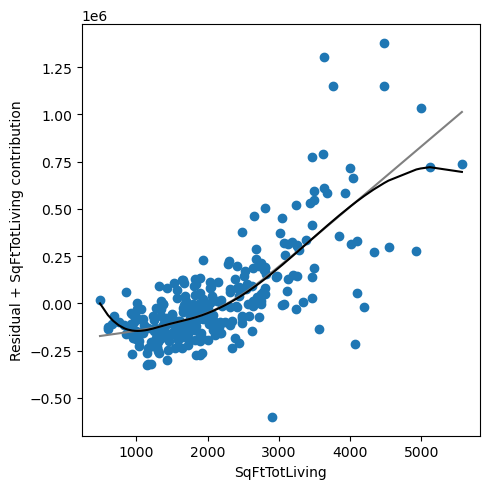

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

In [74]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1677
                                                Scale:                                    29480381715.8293
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

C:\Users\P6049834\AppData\Local\Temp\ipykernel_8204\661170992.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


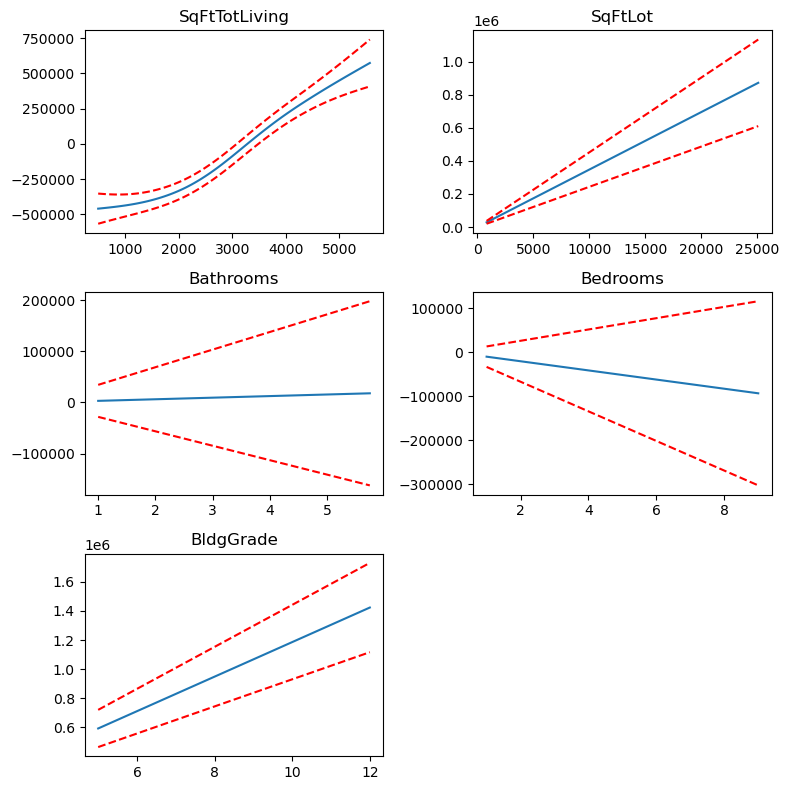

In [75]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()